In [78]:
import re
import os
import pandas as pd
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
from plantuml import PlantUML

In [104]:
df = pd.read_csv("diagrams/diagram_metadata.csv")
df.head(10)

,filename,file_path,diagram_code,diagram_type
0,mermaid_diagram_390.txt,gh_mermaid_data_models/diagram_390.txt,"erDiagram\n""users"" {\n String id PK\n String...",mermaid
1,mermaid_diagram_390.txt,gh_mermaid_data_models/diagram_390.txt,"erDiagram\n""users"" {\n String id PK\n String...",mermaid
2,mermaid_diagram_384.txt,gh_mermaid_data_models/diagram_384.txt,"erDiagram\n\norder ||--|{ item : ""has""\norder ...",mermaid
3,mermaid_diagram_409.txt,gh_mermaid_data_models/diagram_409.txt,erDiagram\n\n Domain {\n text domain_name\...,mermaid
4,mermaid_diagram_1120.txt,gh_mermaid_data_models/diagram_1120.txt,erDiagram\n PAZIENTE ||--o{ PRENOTAZIONE : ...,mermaid
5,mermaid_diagram_1134.txt,gh_mermaid_data_models/diagram_1134.txt,erDiagram\n Users {\n int idUsers PK...,mermaid
6,mermaid_diagram_353.txt,gh_mermaid_data_models/diagram_353.txt,erDiagram\n User {\n int id(PK)\n strin...,mermaid
7,mermaid_diagram_421.txt,gh_mermaid_data_models/diagram_421.txt,erDiagram\n %% Core Entities\n USER {\n ...,mermaid
8,mermaid_diagram_1108.txt,gh_mermaid_data_models/diagram_1108.txt,"erDiagram\n USER ||--|| CART : ""has""\n U...",mermaid
9,mermaid_diagram_347.txt,gh_mermaid_data_models/diagram_347.txt,erDiagram\n %% 数据库ER图\n DOWNLOAD_HISTORY...,mermaid


In [106]:
# Count/distribution of each diagram type
type_counts = df['diagram_type'].value_counts()
type_distribution = df['diagram_type'].value_counts(normalize=True) * 100

print("Count of Diagram Types :")
print(type_counts)

print("Distribution of Diagram Types (%):")
print(type_distribution)

Count of Diagram Types :
diagram_type
mermaid     1607
plantuml     776
Name: count, dtype: int64
Distribution of Diagram Types (%):
diagram_type
mermaid     67.436005
plantuml    32.563995
Name: proportion, dtype: float64


In [116]:
# Count of diagrams per file
df['filename'].value_counts().head(10)
#plantuml = df[df['diagram_type'] == "plantuml"]
#plantuml['filename'].value_counts().head(20)
#df.groupby('diagram_type')['filename'].value_counts().groupby('diagram_type').describe()

filename
mermaid_diagram_201.txt     10
mermaid_diagram_701.txt     10
mermaid_diagram_401.txt     10
mermaid_diagram_101.txt     10
mermaid_diagram_1401.txt    10
mermaid_diagram_901.txt     10
mermaid_diagram_1.txt       10
mermaid_diagram_801.txt     10
mermaid_diagram_1001.txt    10
mermaid_diagram_1301.txt    10
Name: count, dtype: int64

In [86]:
# Most common start line
df['start_line'] = df['diagram_code'].str.split('\n').str[0]
df['start_line'].value_counts().head(10)

start_line
erDiagram                            1517
package "Some Group" {                199
classDiagram                           90
hide empty members                     45
skinparam monochrome true              44
class Car                              30
package "ECサイト" as target_system{      30
skinparam  class {                     16
abstract class AbstractList            16
class Human                            15
Name: count, dtype: int64

In [88]:
# Average diagram length by type
df['char_count'] = df['diagram_code'].str.len()
df['line_count'] = df['diagram_code'].str.count('\n') + 1

df.groupby('diagram_type')['line_count'].mean()

diagram_type
mermaid     46.128811
plantuml    30.411082
Name: line_count, dtype: float64

In [124]:
# Parsing functions for Mermaid diagrams
def count_entities_mermaid(code):
    code = code.strip()
    entity_names = set()

    if code.lower().startswith('erdiagram'):
        # Matches both entity definitions and relationship pairs
        entity_blocks = re.findall(r'(\w+)\s*\{', code)
        relation_lines = re.findall(r'([a-zA-Z0-9_]+)\s+[\|}o{]*--[\|}o{]*\s+([a-zA-Z0-9_]+)', code)
        for e1, e2 in relation_lines:
            entity_names.add(e1)
            entity_names.add(e2)
        for e in entity_blocks:
            entity_names.add(e)

    elif code.lower().startswith('classdiagram'):
        # Match class declarations
        class_entities = re.findall(r'class\s+([a-zA-Z0-9_]+)', code)
        entity_names.update(class_entities)

    return len(entity_names)

def count_relationships_mermaid(code):
    code = code.strip()

    if code.lower().startswith('erdiagram'):
        return len(re.findall(r'([a-zA-Z0-9_]+)\s+[\|}o{]*--[\|}o{]*\s+([a-zA-Z0-9_]+)', code))

    elif code.lower().startswith('classdiagram'):
        return len(re.findall(r'[a-zA-Z0-9_]+\s+--[->]?\s+[a-zA-Z0-9_]+', code))

    return 0


df_mermaid = df[df['diagram_type'] == 'mermaid'].copy()

# Apply the functions only  mermaid diagrams
df_mermaid['num_entities'] = df_mermaid['diagram_code'].apply(count_entities_mermaid)
df_mermaid['num_relationships'] = df_mermaid['diagram_code'].apply(count_relationships_mermaid)

# Merge back into original DataFrame
df = df.merge(
    df_mermaid[['filename', 'num_entities', 'num_relationships']],
    on='filename',
    how='left'
)

In [126]:
# Parsing functions for PlantUML diagrams
def count_entities_plantuml(code):
    entities = set()
    matches = re.findall(r'\b(class|entity|interface|enum)\s+([a-zA-Z_][a-zA-Z0-9_]*)', code)
    for _, name in matches:
        entities.add(name)
    return len(entities)

def count_relationships_plantuml(code):
    # Matches patterns like A --> B, A *-- B, A --|> B, A -->* B, etc.
    return len(re.findall(r'\b[a-zA-Z_][a-zA-Z0-9_]*\s+[-*o<>|/\\]+[->]*\s+[a-zA-Z_][a-zA-Z0-9_]*\b', code))

df['num_entities'] = df.apply(
    lambda row: count_entities_plantuml(row['diagram_code']) if row['diagram_type'] == 'plantuml' else None,
    axis=1
)

df['num_relationships'] = df.apply(
    lambda row: count_relationships_plantuml(row['diagram_code']) if row['diagram_type'] == 'plantuml' else None,
    axis=1
)

In [128]:
print(df[['diagram_type', 'num_entities', 'num_relationships']].describe())

       num_entities  num_relationships
count    776.000000         776.000000
mean       2.453608           3.247423
std        5.264651           5.000709
min        0.000000           0.000000
25%        0.000000           0.000000
50%        0.000000           0.000000
75%        2.000000           6.000000
max       22.000000          20.000000


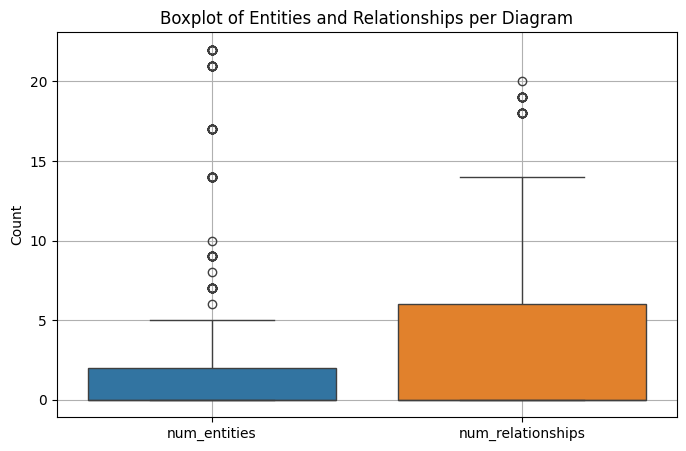

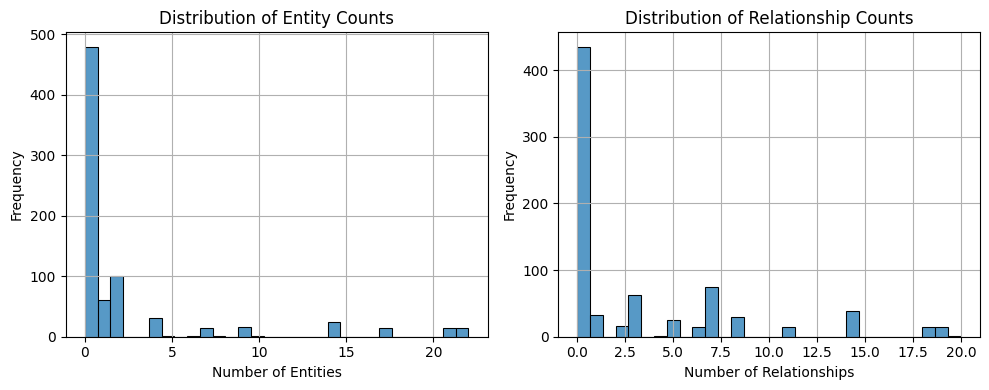

In [132]:
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you already have 'df' with 'num_entities' and 'num_relationships'
plt.figure(figsize=(8, 5))
sns.boxplot(data=df[['num_entities', 'num_relationships']])
plt.title("Boxplot of Entities and Relationships per Diagram")
plt.ylabel("Count")
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 4))

# Entities
plt.subplot(1, 2, 1)
sns.histplot(df['num_entities'], bins=30, kde=False)
plt.title("Distribution of Entity Counts")
plt.xlabel("Number of Entities")
plt.ylabel("Frequency")
plt.grid(True)

# Relationships
plt.subplot(1, 2, 2)
sns.histplot(df['num_relationships'], bins=30, kde=False)
plt.title("Distribution of Relationship Counts")
plt.xlabel("Number of Relationships")
plt.ylabel("Frequency")
plt.grid(True)

plt.tight_layout()
plt.show()


In [136]:
# Most frequent terms
def extract_terms(text):
    words = re.findall(r'\b\w+\b', text)
    # Ignore very short words
    return [w.lower() for w in words if len(w) > 2]

all_terms = []

for code in df['diagram_code']:
    all_terms.extend(extract_terms(code))

term_counter = Counter(all_terms)
common_terms = term_counter.most_common(20)

print("Most common terms across all diagrams:")
for term, freq in common_terms:
    print(f"{term}: {freq}")


Most common terms across all diagrams:
string: 61595
datetime: 24691
nullable: 15060
int: 13872
created_at: 10573
bigint: 8628
varchar: 7522
name: 5331
deleted_at: 4459
erdiagram: 4343
sequence: 3450
user: 3347
float: 3090
updated_at: 2764
class: 2506
shopping_sale_snapshots: 2400
boolean: 2392
shopping_customers: 2100
enum: 2002
text: 1992


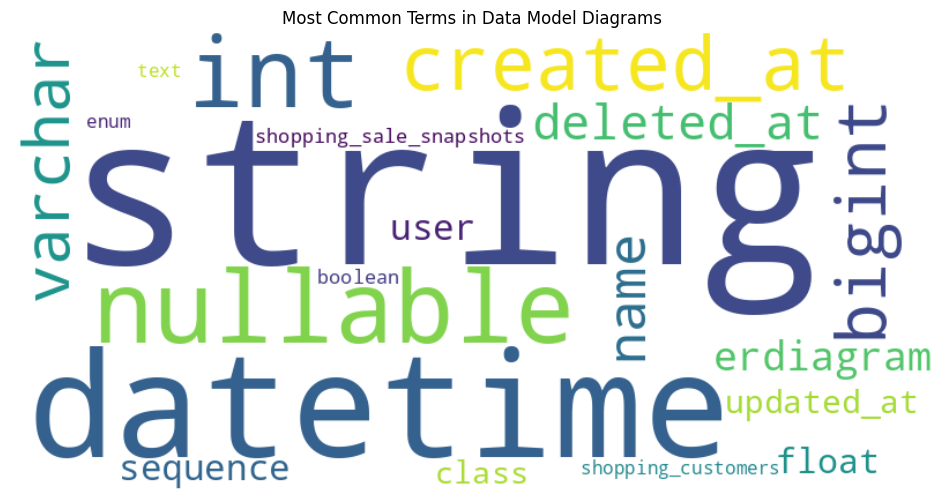

In [144]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

term_frequencies = {
    "string": 61595,
    "datetime": 24691,
    "nullable": 15060,
    "int": 13872,
    "created_at": 10573,
    "bigint": 8628,
    "varchar": 7522,
    "name": 5331,
    "deleted_at": 4459,
    "erdiagram": 4343,
    "sequence": 3450,
    "user": 3347,
    "float": 3090,
    "updated_at": 2764,
    "class": 2506,
    "shopping_sale_snapshots": 2400,
    "boolean": 2392,
    "shopping_customers": 2100,
    "enum": 2002,
    "text": 1992
}

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(term_frequencies)

# Display
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Terms in Data Model Diagrams')
plt.show()
wordcloud.to_file("wordcloud_diagram_terms.png")

In [98]:
# Average connections per entity
df['avg_connections_per_entity'] = df.apply(
    lambda row: row['num_relationships'] / row['num_entities'] if row['num_entities'] > 0 else 0, axis=1
)

print("Average connections per entity (summary):")
print(df['avg_connections_per_entity'].describe())


Average connections per entity (summary):
count    5299.000000
mean        0.078192
std         0.506150
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        20.000000
Name: avg_connections_per_entity, dtype: float64


In [100]:
df['mermaid_type'] = df['diagram_code'].apply(
    lambda x: 'erDiagram' if x.lower().strip().startswith('erdiagram')
    else ('classDiagram' if x.lower().strip().startswith('classdiagram') else 'unknown')
)

df['mermaid_type'].value_counts()

mermaid_type
erDiagram       4343
unknown          776
classDiagram     180
Name: count, dtype: int64

In [169]:
print(df.loc[df['filename'] == "plantuml_diagram_28.txt", 'diagram_code'].values[0])

entity "users" {
    * id : Bigint <<PK>> 
    --
    name : String
}

entity "words" {
    * id : Integer <<PK>>
    --
    word : String
    translation : String
}

entity "userwords" {
    * id : Integer <<PK>>
    --
    word : String
    translation : String
    user_id : Integer <<FK>>
}

users ||--o{ userwords : "has"
